# **Movies Recommendation System**

- **Nama**: Dewi Safira Permata sari
- **Email**: dwsafperri@gmail.com
- **ID Dicoding**: dwsafperri

# **Project Overview**

Dengan terus bertambahnya jumlah film yang tersedia di berbagai platform digital, pengguna sering kesulitan menemukan film yang sesuai dengan selera mereka. Salah satu pendekatan populer untuk mengatasi permasalahan ini adalah sistem rekomendasi berbasis konten (*content-based filtering*), di mana rekomendasi diberikan berdasarkan kesamaan karakteristik konten — dalam hal ini, genre film.

Proyek ini bertujuan membangun **sistem rekomendasi film berdasarkan genre** menggunakan pendekatan content-based filtering. Misalnya, jika seorang pengguna menyukai film King Kong, maka sistem akan merekomendasikan film lain yang memiliki genre serupa seperti Action, Adventure, atau Horror.

Sistem ini relevan karena membantu pengguna mengeksplorasi film yang mungkin belum pernah mereka tonton namun memiliki karakteristik yang mereka sukai. Selain itu, pendekatan ini tidak memerlukan data interaksi pengguna lain, sehingga cocok untuk kondisi cold start atau sistem baru.

# **Business Understanding**

## **Problem Statements**

1. Bagaimana cara merepresentasikan informasi genre film secara numerik agar bisa digunakan dalam perhitungan kemiripan antar film?

2. Bagaimana cara mengukur tingkat kemiripan antar film hanya berdasarkan informasi kontennya, khususnya genre?

3. Bagaimana cara mengembangkan sistem rekomendasi film yang mampu memberikan saran film sejenis hanya dari satu input judul film?


## **Goals**

1. Menghasilkan sistem rekomendasi film yang mampu menyarankan film lain dengan genre yang mirip dari input satu judul film.

2. Memudahkan pengguna menemukan film-film baru sesuai dengan preferensi genre mereka tanpa perlu memberikan penilaian eksplisit.

3. Membuat sistem yang bersifat general dan bisa digunakan tanpa ketergantungan pada data pengguna (user rating history).

## **Solution Statements**

1. Menggunakan pendekatan content-based filtering dengan teknik TF-IDF vectorization untuk merepresentasikan genre film.

2. Mengukur kemiripan antar film menggunakan cosine similarity untuk menentukan film-film yang memiliki kemiripan konten.

3. Mengimplementasikan fungsi rekomendasi yang menerima judul film sebagai input dan menghasilkan daftar rekomendasi berdasarkan tingkat kemiripan genre.

# **Data Understanding**

Tahap *Data Understanding* bertujuan untuk mengenal struktur, isi, dan karakteristik data yang akan digunakan. Dalam proyek ini, digunakan dua dataset utama dari [Kaggle - The Movies Dataset](https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset), yaitu `ratings.csv` dan `movies_metadata.csv`. Proses understanding mencakup membaca data, memeriksa struktur kolom dan tipe datanya, serta melakukan eksplorasi awal seperti statistik deskriptif untuk mengidentifikasi pola umum, missing values, dan anomali. Karena ukuran dataset cukup besar, dilakukan *sampling* sebanyak 10.000 baris untuk masing-masing file guna mempercepat proses eksplorasi dan pengolahan selanjutnya.

## **1. Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

import warnings
warnings.filterwarnings('ignore')

## **2. Load Dataset**

In [2]:
#!/bin/bash
!curl -L -o the-movies-dataset.zip\
  'https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  227M  100  227M    0     0  82.8M      0  0:00:02  0:00:02 --:--:--  114M


In [3]:
!unzip -q the-movies-dataset.zip

### Deskripsi Variabel


In [4]:
data_ratings = pd.read_csv("/content/ratings.csv")
data_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


**Insight :**

Data ratings memiliki 26.024.289 baris dan 4 fitur.

| **Kolom**   | **Deskripsi**                                                                 |
| ----------- | ----------------------------------------------------------------------------- |
| `userId`    | ID pengguna yang memberikan rating.                                           |
| `movieId`   | ID film yang diberi rating.                                                   |
| `rating`    | Nilai rating yang diberikan oleh pengguna (biasanya skala 1.0–5.0).           |
| `timestamp` | Waktu pemberian rating dalam format Unix timestamp (jumlah detik sejak 1970). |

Dikarenakan jumlah data yang terlalu banyak, maka data yang diambil hanya 10.000 data.


In [5]:
ratings = data_ratings.sample(n=10000, random_state=42)
ratings.shape

(10000, 4)

**Insight :**

Data ratings berhasil di filter sebanyak 10.000 data.

In [6]:
data_movies = pd.read_csv("/content/movies_metadata.csv")
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

**Insight :**

Data movies memiliki 45.466 baris dan 24 kolom.

| **Kolom**               | **Deskripsi**                                             |
| ----------------------- | --------------------------------------------------------- |
| `adult`                 | Menandakan apakah film untuk dewasa (`True`/`False`).     |
| `belongs_to_collection` | Informasi jika film bagian dari seri/koleksi.             |
| `budget`                | Anggaran produksi film (biasanya dalam USD).              |
| `genres`                | Daftar genre film.                                        |
| `homepage`              | URL resmi film (jika tersedia).                           |
| `id`                    | ID unik film (dari TMDB).                                 |
| `imdb_id`               | ID film di IMDb.                                          |
| `original_language`     | Bahasa asli film (contoh: `en` untuk Inggris).            |
| `original_title`        | Judul asli film.                                          |
| `overview`              | Ringkasan atau sinopsis film.                             |
| `popularity`            | Skor popularitas dari TMDB.                               |
| `poster_path`           | Path ke poster film.                                      |
| `production_companies`  | Daftar perusahaan produksi.                               |
| `production_countries`  | Negara tempat film diproduksi.                            |
| `release_date`          | Tanggal rilis film.                                       |
| `revenue`               | Pendapatan film (dalam USD).                              |
| `runtime`               | Durasi film dalam menit.                                  |
| `spoken_languages`      | Bahasa yang digunakan dalam film.                         |
| `status`                | Status rilis film (misal: `Released`, `Post Production`). |
| `tagline`               | Slogan atau tagline film.                                 |
| `title`                 | Judul film (umumnya untuk keperluan tampilan).            |
| `video`                 | Apakah data ini berupa video (`True`/`False`).            |
| `vote_average`          | Rata-rata rating dari pengguna.                           |
| `vote_count`            | Jumlah total suara (rating) yang masuk.                   |

Dikarenakan jumlah data yang terlalu banyak, maka data yang diambil hanya 10.000 data.

In [7]:
movies = data_movies.sample(n=10000, random_state=42)
movies.shape

(10000, 24)

In [8]:
print('Jumlah data ratings: ', len(ratings.userId.unique()))
print('Jumlah data movies yang direview: ', len(movies.id.unique()))

Jumlah data ratings:  9193
Jumlah data movies yang direview:  9999


**Insight :**

Data movies berhasil di filter sebanyak 10.000 data.

### Deskripsi Statistik

In [9]:
ratings.describe()

,userId,movieId,rating,timestamp
count,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,135301.839200,16094.933000,3.528300,1.172021e+09
std,78033.800369,31684.840205,1.069796,2.067847e+08
min,8.000000,1.000000,0.500000,8.256384e+08
25%,67780.750000,1036.750000,3.000000,9.876250e+08
50%,135972.000000,2565.000000,3.500000,1.153308e+09
75%,202405.500000,6534.000000,4.000000,1.360613e+09
max,270761.000000,174615.000000,5.000000,1.501817e+09


**Insight :**

| **Kolom**     | **Insight Utama**                                                                                                                                        |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **userId**    | - 10.000 data unik dengan userId rata-rata 135.302, rentang luas (8 – 270.761) <br> - Variasi user tinggi, artinya banyak user berbeda                   |
| **movieId**   | - Rentang sangat luas (1 – 174.615), rata-rata 16.095 <br> - Kuartil bawah jauh lebih kecil dari max, menunjukkan distribusi tidak merata (skewed)       |
| **rating**    | - Rata-rata 3.53 dengan rentang 0.5 – 5 <br> - Sebagian besar rating di 3 – 4 (median 3.5), menunjukkan rating cenderung positif                         |
| **timestamp** | - Rentang waktu cukup luas (sekitar 825 juta – 1,5 miliar UNIX timestamp) <br> - Distribusi waktu data merata, artinya pengambilan data berlangsung lama |


In [10]:
movies.describe()

,revenue,runtime,vote_average,vote_count
count,9.999000e+03,9943.000000,9999.000000,9999.000000
mean,1.076734e+07,94.291361,5.611591,107.505051
std,5.771824e+07,36.845927,1.929366,464.646286
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,35.000000
max,1.156731e+09,900.000000,10.000000,12269.000000


**Insight :**

| **Kolom**         | **Insight Utama**                                                                                                                                                                                                                                                                      |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **revenue**       | - Rata-rata sekitar 10.7 juta, tapi sangat bervariasi (std \~57 juta) <br> - 75% film punya revenue 0, artinya banyak film yang tidak menghasilkan pendapatan tercatat (atau nol) <br> - Maksimum sangat besar, mencapai 1,16 miliar, ada beberapa blockbuster saja yang sangat tinggi |
| **runtime**       | - Rata-rata durasi film sekitar 94 menit <br> - Rentang durasi cukup luas, dari 0 (mungkin data hilang/tidak valid) sampai 900 menit <br> - Kuartil menunjukkan mayoritas film berdurasi antara 85 sampai 107 menit                                                                    |
| **vote\_average** | - Rata-rata rating suara film 5.61 (skala 0–10) <br> - Sebagian besar film mendapat nilai sekitar 5–7 <br> - Nilai maksimum 10, nilai minimum 0 (mungkin film yang belum mendapat vote)                                                                                                |
| **vote\_count**   | - Rata-rata jumlah vote 107, tapi distribusi sangat skewed (std 464) <br> - Banyak film dengan vote rendah (kuartil 25% = 3), beberapa film sangat populer dengan hingga 12.269 vote                                                                                                   |


## **3. Exploratory Data Analysis**

Exploratory Data Analysis (EDA) dilakukan untuk memahami pola, anomali, serta hubungan antar fitur dalam dataset sebelum masuk ke tahap pemodelan. Dalam proses ini, dilakukan visualisasi distribusi data seperti rating film, tahun rilis, durasi, hingga korelasi antar fitur numerik. EDA juga membantu dalam pengambilan keputusan terhadap data mana yang perlu dibersihkan, difilter, atau dipertahankan.

### **a. Distribusi Rating**

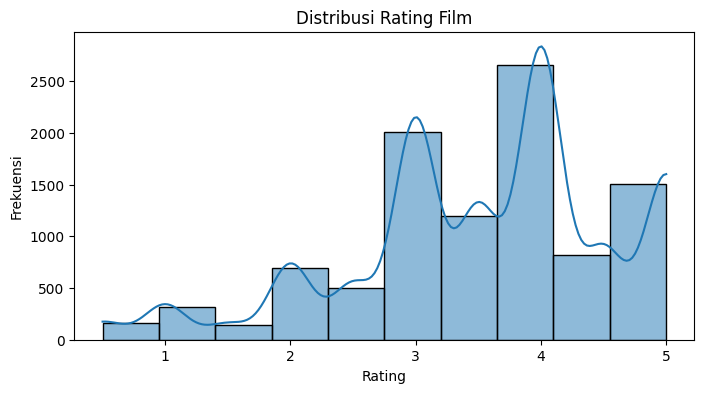

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

**Insight :**

1. **Sebaran Rating Tidak Merata (Right-skewed)**

   * Distribusi rating condong ke kanan, yang berarti lebih banyak film yang mendapatkan rating tinggi (antara 3 hingga 5).
   * Hanya sedikit film yang mendapat rating rendah (kurang dari 2).

2. **Rating Populer di Skor 3 dan 4**

   * Puncak tertinggi histogram (frekuensi paling besar) berada pada rating **3 dan 4**, menunjukkan bahwa sebagian besar pengguna memberikan rating di kisaran ini.

3. **Rating Sempurna (5) Juga Cukup Banyak**

   * Terlihat ada lonjakan lagi di rating **5**, menunjukkan bahwa cukup banyak pengguna yang memberikan nilai sempurna pada film tertentu.

4. **Rating Ekstrem (0 - 1) Sangat Jarang**

   * Frekuensi pada nilai rating mendekati 0 hampir tidak ada, artinya sangat sedikit film yang dianggap "buruk sekali" oleh penonton.




### **b. Distribusi Tahun Rilis Film**

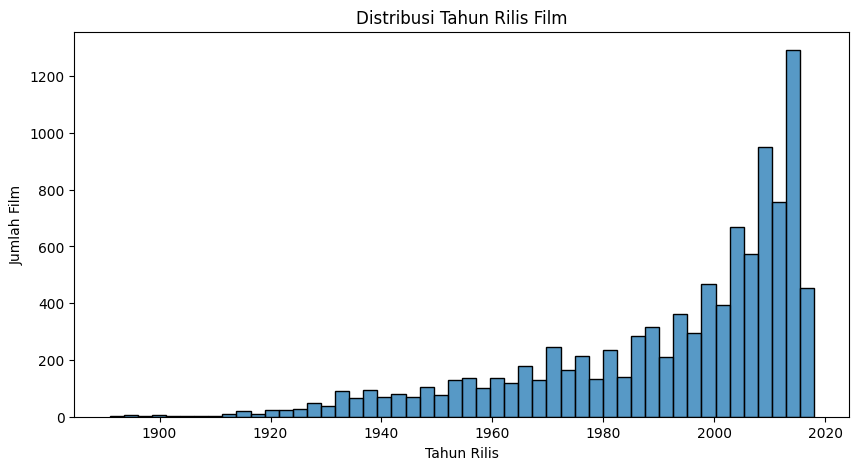

In [12]:
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['release_year'] = movies['release_date'].dt.year

plt.figure(figsize=(10,5))
sns.histplot(movies['release_year'].dropna().astype(int), bins=50)
plt.title('Distribusi Tahun Rilis Film')
plt.xlabel('Tahun Rilis')
plt.ylabel('Jumlah Film')
plt.show()

**Insight :**


1. **Jumlah Film Meningkat Signifikan Setelah Tahun 1980-an**

   * Terlihat pertumbuhan tajam jumlah film mulai dari tahun 1980-an hingga puncaknya di sekitar tahun 2010–2015.
   * Hal ini mencerminkan kemajuan teknologi produksi, distribusi digital, dan platform streaming.

2. **Ledakan Produksi Film Era 2000-an**

   * Puncak tertinggi terjadi di rentang tahun **2010–2015**, dengan lebih dari 1.200 film dirilis per tahun.
   * Bisa jadi ini efek dari munculnya studio independen, kemudahan akses teknologi kamera, atau kemunculan platform seperti YouTube dan Netflix.

3. **Produksi Rendah di Awal Abad ke-20**

   * Produksi film sangat sedikit sebelum tahun 1950-an, yang wajar karena industri perfilman masih sangat baru saat itu.

4. **Penurunan di Akhir Distribusi (sekitar 2020)**

   * Ada penurunan tajam setelah 2015–2020. Ini kemungkinan disebabkan oleh:

     * **Data belum lengkap** (film baru belum semuanya masuk ke database).
     * **Pandemi COVID-19**, yang menyebabkan banyak produksi film tertunda atau dibatalkan.

5. **Distribusi Positively Skewed (Kanan)**

   * Sebagian besar data terkonsentrasi di era modern, menunjukkan tren meningkat seiring waktu.


### **c. Distribusi Runtime**

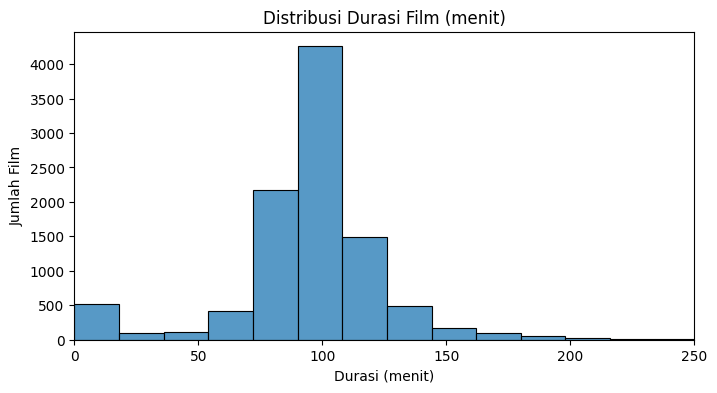

In [13]:
plt.figure(figsize=(8,4))
sns.histplot(movies['runtime'].dropna(), bins=50)
plt.title('Distribusi Durasi Film (menit)')
plt.xlabel('Durasi (menit)')
plt.ylabel('Jumlah Film')
plt.xlim(0, 250)  # Batasi sumbu X dari 0 sampai 250 menit
plt.show()

**Insight :**

1. Film paling umum berdurasi 90–100 menit.

2. Ada sejumlah kecil film yang sangat pendek atau panjang, tapi tidak mendominasi.

3. Durasi 0 kemungkinan perlu diperlakukan sebagai data tidak valid dalam analisis lanjutan.


### **d. Rating Rata-Rata per Film**

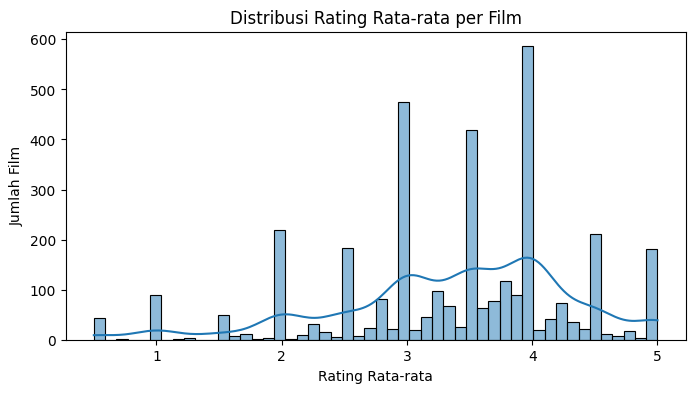

In [14]:
avg_rating = ratings.groupby('movieId')['rating'].mean()

plt.figure(figsize=(8,4))
sns.histplot(avg_rating, bins=50, kde=True)
plt.title('Distribusi Rating Rata-rata per Film')
plt.xlabel('Rating Rata-rata')
plt.ylabel('Jumlah Film')
plt.show()

  **Insight :**

  1. **Distribusi Berbentuk Mendekati Normal, Tapi Tidak Sempurna**

    * Sebagian besar film memiliki rating rata-rata antara **2.5 hingga 4.0**, yang merupakan kisaran "cukup hingga bagus".
    * Puncak distribusi ada di sekitar **rating 3.5–4.0**, menandakan banyak film mendapatkan respons positif dari penonton.

  2. **Pola Bar yang "Bergelombang"**

    * Ada lonjakan tajam di rating bulat seperti **3.0**, **4.0**, dan **5.0**.
    * Hal ini mengindikasikan:

      * Banyak penonton yang cenderung memberi rating bulat, bukan desimal.
      * Atau, rating rata-rata bulat terjadi karena banyak film memiliki jumlah rating sedikit.

  3. **Film dengan Rating Sangat Rendah (1.0–2.0) Relatif Sedikit**

    * Ini menunjukkan bahwa sangat sedikit film yang dianggap buruk secara universal.
    * Bisa juga disebabkan karena film yang sangat buruk tidak banyak ditonton/rated.

  4. **Ada Film dengan Rating Mendekati 5.0**

    * Menunjukkan bahwa ada beberapa film yang sangat disukai oleh penonton (cult classics atau masterpiece).

  5. **Skewness Tidak Terlalu Ekstrem**

    * Distribusi relatif simetris dengan kecenderungan sedikit ke kanan, artinya film cenderung mendapat nilai lebih tinggi daripada rendah.


### **e. Korelasi Antar Fitur Numerik Film**

In [15]:
# Hitung jumlah rating per film
ratings_count = ratings.groupby('movieId').size().rename('rating_count')

# Hitung rata-rata rating per film
avg_rating = ratings.groupby('movieId')['rating'].mean().rename('average_rating')

# Gabungkan ke movies_metadata pakai 'movieId' (pastikan ada kolom yang sama)
movies_subset = movies[['id', 'runtime', 'release_year']].copy()
movies_subset['id'] = movies_subset['id'].astype(str)

# Convert movieId ke string agar bisa merge
ratings_count.index = ratings_count.index.astype(str)
avg_rating.index = avg_rating.index.astype(str)

# Gabungkan semua data
df_corr = movies_subset.set_index('id').join([ratings_count, avg_rating])

# Drop baris dengan nilai NaN
df_corr = df_corr.dropna()

df_corr.head()

,runtime,release_year,rating_count,average_rating
id,,,,
4975,90.0,1998.0,5.0,2.7
6283,98.0,1997.0,1.0,3.5
1588,98.0,2000.0,3.0,3.0
67255,102.0,1984.0,3.0,3.5
1253,129.0,2006.0,2.0,4.0


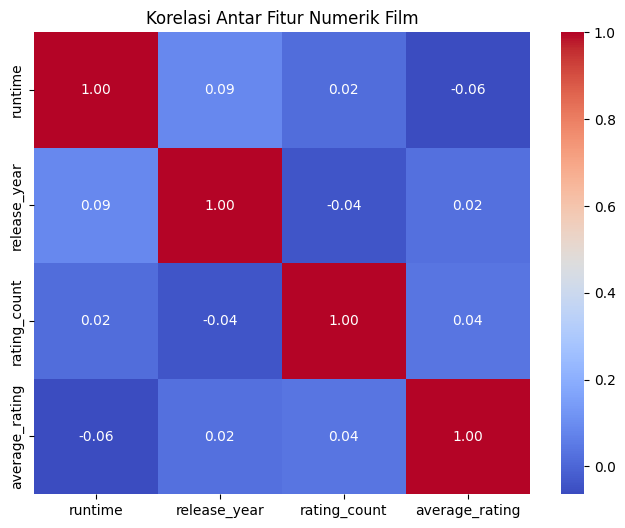

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung korelasi
corr = df_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur Numerik Film')
plt.show()

**Insight :**

| Fitur 1        | Fitur 2          | Korelasi  | Interpretasi                                                                                                            |
| -------------- | ---------------- | --------- | ----------------------------------------------------------------------------------------------------------------------- |
| `runtime`      | `release_year`   | **0.09**  | Korelasi sangat lemah dan positif → film makin modern cenderung sedikit lebih panjang durasinya, tapi tidak signifikan. |
| `runtime`      | `average_rating` | **-0.06** | Korelasi sangat lemah dan negatif → durasi film tidak berpengaruh signifikan terhadap rating.                           |
| `release_year` | `average_rating` | **0.02**  | Hampir tidak ada hubungan antara tahun rilis dan rating. Film lama atau baru punya peluang yang sama untuk disukai.     |
| `rating_count` | `average_rating` | **0.04**  | Hampir tidak ada korelasi → jumlah rating tidak menunjukkan apakah film disukai atau tidak.                             |
| `runtime`      | `rating_count`   | **0.02**  | Tidak ada hubungan berarti antara panjang film dan seberapa banyak orang menontonnya.                                   |


- Semua fitur memiliki korelasi rendah (< 0.1) → artinya tidak ada hubungan linear kuat antar fitur numerik.
Ini menunjukkan bahwa:
  - Popularitas (jumlah rating) dan kualitas (rating rata-rata) tidak selalu berjalan beriringan.

  - Durasi film bukan indikator utama apakah film disukai atau tidak.

  - Tahun rilis juga bukan penentu utama untuk nilai atau popularitas film

### **f. Top 10 Movies Berdasarkan Popularity**

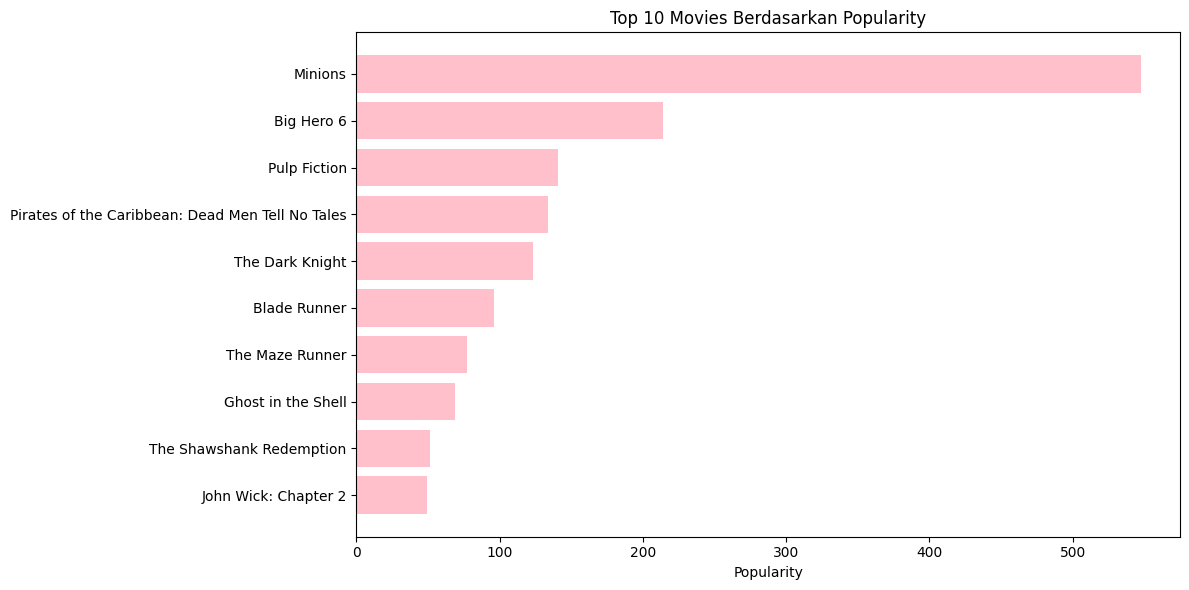

In [17]:
import pandas as pd

movies['popularity'] = pd.to_numeric(movies['popularity'], errors='coerce')

# Drop data yang popularity-nya kosong
movies_clean = movies.dropna(subset=['popularity'])

# Urutkan berdasarkan popularity tertinggi dan ambil top 10
top_10_movies = movies_clean.sort_values(by='popularity', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12,6))
plt.barh(top_10_movies['title'][::-1], top_10_movies['popularity'][::-1], color='pink')
plt.xlabel('Popularity')
plt.title('Top 10 Movies Berdasarkan Popularity')
plt.tight_layout()
plt.show()

**Insight :**

1. **Film paling populer** secara signifikan adalah **Minions** — dengan selisih yang **sangat besar** dibanding film lainnya. Ini menunjukkan bahwa film ini mendapat perhatian luar biasa dari audiens (kemungkinan dari anak-anak, keluarga, dan strategi promosi besar-besaran).

2. **Big Hero 6** menempati posisi ke-2, masih cukup jauh dibanding Minions, tapi jauh di atas posisi ke-3 (Pulp Fiction). Ini menunjukkan bahwa film animasi dari studio besar punya daya tarik populer yang kuat.

3. **Kombinasi genre** menarik perhatian:

   * Ada film **animasi dan keluarga** (Minions, Big Hero 6).
   * Film **aksi dan superhero** (The Dark Knight, Blade Runner, John Wick).
   * Film **drama dan klasik** (The Shawshank Redemption, Pulp Fiction).

4. **Film lama tetap bisa populer** — seperti *Pulp Fiction* dan *The Shawshank Redemption*. Ini menandakan bahwa faktor usia tidak selalu mengurangi popularitas jika film punya kualitas atau status "cult classic".

**Insight Tambahan**

* **Popularitas ≠ Rating Tinggi**
  Beberapa film populer seperti *Minions* mungkin tidak memiliki rating tertinggi secara kritis, tapi tetap banyak ditonton karena **segmentasi pasar dan daya tarik massal**.


## **4. Data Preparation**

Sebelum dilakukan analisis atau pemodelan lebih lanjut, data perlu dibersihkan dan disiapkan. Tahapan ini meliputi konversi format data, merge antar tabel, mengatasi missing value, outlier, dan menyiapkan fitur agar siap dianalisis.


### a. Mengubah Dictionary menjadi String

In [18]:
# Fungsi untuk memformat kolom 'genres' dari string menjadi format string genre yang dipisahkan tanda '|'
def format_genres(genre_string):
    # Tangani nilai NaN atau tipe data non-string
    if pd.isna(genre_string) or not isinstance(genre_string, str):
        return ""

    try:
        # Ubah string literal menjadi list of dict menggunakan ast.literal_eval
        parsed_genres = ast.literal_eval(genre_string)
    except (ValueError, SyntaxError) as e:
        # Jika parsing gagal, tampilkan peringatan dan kembalikan string kosong
        print(f"Warning: Tidak dapat parsing genre string '{genre_string}'. Error: {e}")
        return ""

    # Ambil nilai 'name' dari setiap dictionary dalam list dan gabungkan dengan delimiter '|'
    genre_names = [genre['name'] for genre in parsed_genres if 'name' in genre]
    return " | ".join(genre_names)

# Pilih kolom yang relevan dari DataFrame 'movies'
df = movies[['id', 'title']].copy()

# Terapkan fungsi format_genres ke kolom 'genres' dan simpan ke kolom baru
df['genres'] = movies['genres'].apply(format_genres)

# Susun ulang kolom dan ubah nama kolom 'id' menjadi 'movieId'
df = df[['id', 'title', 'genres']].rename(columns={'id': 'movieId'})

# Tampilkan 5 data teratas sebagai sampel
df.head()

,movieId,title,genres
43526,411405,Small Crimes,Drama | Comedy | Thriller | Crime
6383,42492,Up the Sandbox,Drama | Comedy
3154,12143,Bad Lieutenant,Crime | Drama
10146,9976,Satan's Little Helper,Horror | Romance | Comedy
9531,46761,Sitcom,Comedy | Drama | Thriller


**Insight :**

Data berhasil diubah dari format string kompleks menjadi format yang lebih sederhana dan mudah dipakai, dan disimpan dalam dataframe `df`.

### **b. Mengubah tipe data movieId menjadi string**

In [19]:
## Mengubah tipe data movieId menjadi string
df['movieId'] = df['movieId'].astype(str)
ratings['movieId'] = ratings['movieId'].astype(str)

df.info()
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 43526 to 27147
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10000 non-null  object
 1   title    9999 non-null   object
 2   genres   10000 non-null  object
dtypes: object(3)
memory usage: 312.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 11928665 to 13549562
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     10000 non-null  int64  
 1   movieId    10000 non-null  object 
 2   rating     10000 non-null  float64
 3   timestamp  10000 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 390.6+ KB


**Insight :**

Kolom movieId pada dataframe df dan ratings diubah menjadi string.

### c. Merge Data

In [20]:
movie_merged = pd.merge(ratings, df, on='movieId',how="inner")
movie_merged

,userId,movieId,rating,timestamp,title,genres
0,43059,1367,4.0,1088197740,Rocky II,Drama
1,255724,4975,1.0,1082336474,Love Is the Devil: Study for a Portrait of Fra...,TV Movie | Drama
2,246259,587,4.0,945228093,Big Fish,Adventure | Fantasy | Drama
3,72228,3022,3.5,1117138601,Dr. Jekyll and Mr. Hyde,Drama | Horror | Science Fiction
4,218871,5991,3.5,1287676841,The Last Laugh,Drama
...,...,...,...,...,...,...
987,116964,2734,3.0,1008741797,David,Drama | History
988,152250,69928,4.0,1339373959,The Man Who Loved Women,Comedy
989,118327,2108,4.0,1017621443,The Breakfast Club,Comedy | Drama
990,183641,919,4.0,1454248623,Blood: The Last Vampire,Fantasy | Animation | Horror | Comedy | Thrill...


**Insight :**

Data berhasil di merge berdasarkan kolom `movieId` dengan jumlah data 992 baris dan 6 kolom.

### d. Handle Missing Values

In [21]:
movie_merged.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


**Insight :**

Tidak terdapat missing values.

### e. Handle Duplicated Data

In [22]:
movie_merged.duplicated().sum()

np.int64(0)

**Insight :**

Tidak terdapat data duplicate

### f. Menangani Outlier dengan IQR Method

In [23]:
movie_merged.describe()

,userId,rating,timestamp
count,992.000000,992.000000,9.920000e+02
mean,135549.329637,3.507056,1.102484e+09
std,79588.599993,1.048737,2.000154e+08
min,524.000000,0.500000,8.262947e+08
25%,66147.000000,3.000000,9.453043e+08
50%,134592.000000,3.500000,1.081062e+09
75%,204413.250000,4.000000,1.246110e+09
max,270566.000000,5.000000,1.501292e+09


In [24]:
# Mengganti Nilai Outlier dengan Batas Atas dan Batas Bawah Data

for i in movie_merged.select_dtypes(include='number'):
    Q1 = movie_merged[i].quantile(0.25)
    Q3 = movie_merged[i].quantile(0.75)
    IQR = Q3 - Q1

    maximum = Q3 + (1.5 * IQR)
    minimum = Q1 - (1.5 * IQR)

    movie_merged[i] = movie_merged[i].mask(movie_merged[i] > maximum, maximum)
    movie_merged[i] = movie_merged[i].mask(movie_merged[i] < minimum, minimum)

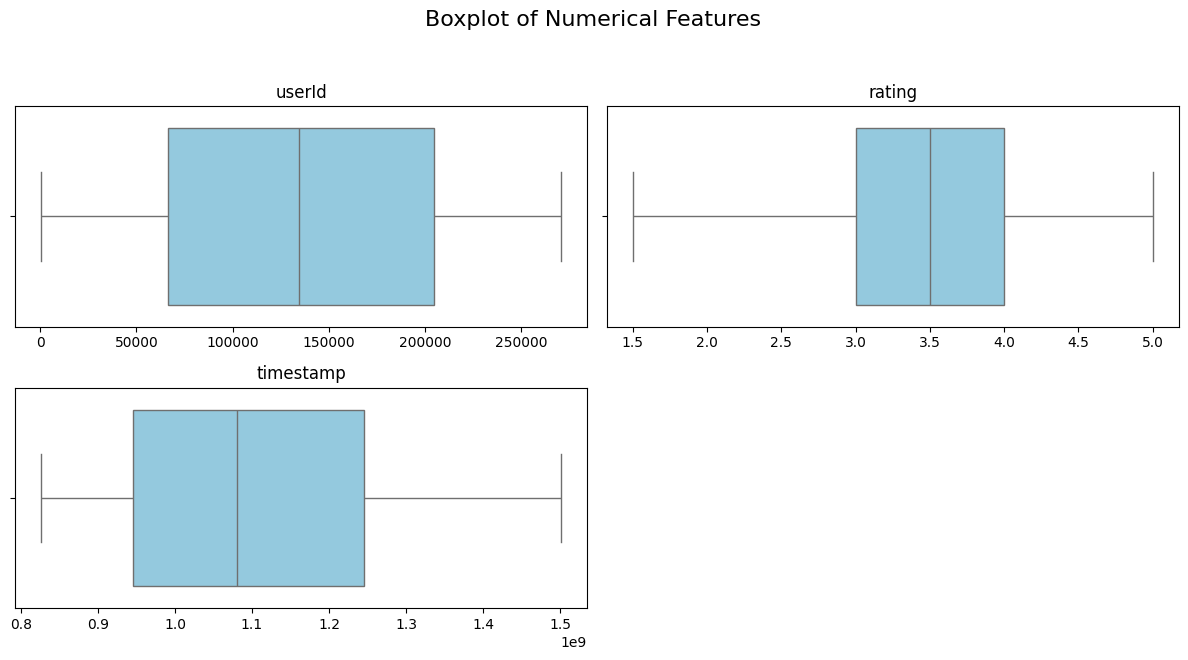

In [25]:
# Buat grid 3x3
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
fig.suptitle('Boxplot of Numerical Features', fontsize=16)

# Flatten axes supaya bisa di-loop
axes = axes.flatten()

# Loop fitur dan plot
numerical_feature = ['userId', 'rating', 'timestamp']
for i, feature in enumerate(numerical_feature):
    sns.boxplot(data=movie_merged, x=feature, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('')

# Sembunyikan subplot yang tidak dipakai (jika jumlah fitur < jumlah grid)
for j in range(len(numerical_feature), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Agar tidak ketimpa judul
plt.show()

**Insight :**

| Fitur         | Insight                                                                                                                                                              |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **userId**    | Distribusi user cukup merata tanpa outlier. Semua nilai userId berada dalam rentang wajar (0–270k). Tidak ada titik ekstrem.                                         |
| **rating**    | Rentang rating hanya dari 0.5 hingga 5, dan sudah **tidak ada outlier**. Distribusi simetris dengan median sekitar 3.5. Artinya sistem rating berjalan sesuai skala. |
| **timestamp** | Distribusi waktu rating (dalam format Unix timestamp) juga sudah **tanpa outlier**. Data berkisar dari sekitar 2007 hingga 2017.                                     |

**Kesimpulan :**

* Penanganan outlier berhasil — tidak ada lagi nilai ekstrem atau titik individu terisolasi pada semua fitur numerik.
* Data siap digunakan untuk analisis atau modeling lebih lanjut karena sudah bersih dan stabil.


### g. Memecah genres yang dipisahkan oleh |

In [26]:
genres = set()
for genres_str in movie_merged['genres']:
    if genres_str: # Only process non-empty strings
        for genre in genres_str.split(' | '):
            genres.add(genre.strip())

genres_list = list(genres)
print(genres_list)

['Crime', 'Animation', 'Comedy', 'Thriller', 'Romance', 'Adventure', 'Foreign', 'Documentary', 'Science Fiction', 'Family', 'War', 'Drama', 'Action', 'Fantasy', 'Western', 'History', 'TV Movie', 'Mystery', 'Music', 'Horror']


**Insight :**

Kode ini mengambil semua genre dari kolom genres pada DataFrame movie_merged, di mana setiap entri genre dipisahkan oleh karakter ' | '. Fungsi .str.get_dummies(sep=' | ') memisahkan string genre berdasarkan delimiter tersebut, kemudian membuat kolom biner (dummy variables) untuk masing-masing genre yang unik.

Setiap kolom baru mewakili satu genre, dan nilainya 1 jika film tersebut memiliki genre tersebut, atau 0 jika tidak. Setelah itu, DataFrame dummy tersebut digabungkan kembali ke movie_merged dengan pd.concat() secara horizontal (axis=1), sehingga dataset kini memiliki representasi genre dalam bentuk numerik


# **Model Development dengan Content Based Features**

Untuk membangun sistem rekomendasi film berbasis konten, pendekatan yang digunakan adalah **content-based filtering**, yang merekomendasikan film berdasarkan kemiripan kontennya — dalam hal ini adalah **genre**. Langkah-langkah pengembangannya dijelaskan sebagai berikut:

**TF-IDF Vectorizer**

Pertama-tama, informasi genre dari setiap film diubah menjadi representasi numerik menggunakan **TF-IDF (Term Frequency - Inverse Document Frequency)**. TF-IDF adalah teknik yang sering digunakan dalam pemrosesan teks untuk merepresentasikan seberapa penting suatu kata (dalam hal ini, genre) dalam suatu dokumen (film) dibandingkan dengan seluruh kumpulan dokumen (film-film lain).

* **Term Frequency (TF)** mengukur seberapa sering suatu genre muncul dalam data film tersebut.
* **Inverse Document Frequency (IDF)** menurunkan bobot genre yang terlalu umum (misalnya "drama" mungkin muncul di banyak film), sehingga genre yang lebih unik mendapat bobot lebih tinggi.

Hasil dari proses ini adalah **matriks TF-IDF**, di mana setiap baris merepresentasikan satu film dan setiap kolom mewakili satu genre. Nilai-nilai dalam matriks ini menunjukkan seberapa kuat keterkaitan film tersebut dengan masing-masing genre.

**Cosine Similarity**

Setelah setiap film direpresentasikan sebagai vektor TF-IDF, langkah berikutnya adalah mengukur tingkat kemiripan antar film. Untuk ini digunakan **cosine similarity**, yaitu ukuran kesamaan antara dua vektor berdasarkan sudut di antara mereka.

* Nilai cosine similarity berkisar antara **0** (tidak mirip sama sekali) hingga **1** (sangat mirip).
* Dua film dianggap mirip jika genre-nya memiliki distribusi yang serupa dalam representasi TF-IDF mereka.

Dengan menggunakan cosine similarity, sistem dapat mencari film yang paling dekat (mirip) vektornya dengan film input, dan merekomendasikannya ke pengguna.


### a. TF-IDF Vectorizer

Langkah pertama adalah mengubah teks pada kolom `genres` menjadi representasi numerik menggunakan **TF-IDF (Term Frequency - Inverse Document Frequency)**. Proses ini bertujuan untuk mengetahui seberapa penting suatu genre (seperti *action*, *drama*, *comedy*, dll.) dalam keseluruhan kumpulan data film:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer()

# Melakukan perhitungan idf pada data genres
tfidf.fit(movie_merged['genres'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fiction', 'foreign',
       'history', 'horror', 'movie', 'music', 'mystery', 'romance',
       'science', 'thriller', 'tv', 'war', 'western'], dtype=object)

**Insight:**

Ini adalah proses transformasi data teks pada kolom `genres` menjadi representasi numerik menggunakan teknik TF-IDF, yang bertujuan untuk mengetahui seberapa penting suatu genre (seperti 'action', 'drama', 'comedy', dll.) dalam keseluruhan kumpulan data film berdasarkan frekuensi kemunculannya secara proporsional.


In [28]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(movie_merged['genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(992, 22)

In [29]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.69140498, 0.        ,
         0.        ],
        [0.        , 0.59553039, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.52798862, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

**Insight:**

Data genre dari 992 film berhasil dikonversi menjadi matriks TF-IDF berukuran 992×22, yang menunjukkan bobot pentingnya masing-masing dari 22 genre untuk setiap film, sehingga memungkinkan analisis berbasis teks yang lebih numerik dan terukur.


In [30]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis genre
# Baris diisi dengan judul movie

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=movie_merged.title
).sample(22, axis=1).sample(10, axis=0)

,war,adventure,music,tv,fiction,documentary,drama,horror,romance,mystery,...,history,family,fantasy,comedy,foreign,thriller,western,movie,animation,science
title,,,,,,,,,,,,,,,,,,,,,
October (Ten Days that Shook the World),0.0,0.00000,0.000000,0.0,0.0,0.945652,0.325181,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
The Way of the Gun,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.337843,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.510511,0.0,0.0,0.0,0.0
The Green Mile,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.351208,0.0,0.000000,0.0,...,0.0,0.000000,0.709958,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Saw II,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Big Fish,0.0,0.59553,0.000000,0.0,0.0,0.000000,0.356199,0.0,0.000000,0.0,...,0.0,0.000000,0.720046,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
Italian for Beginners,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.382776,0.0,0.733888,0.0,...,0.0,0.000000,0.000000,0.561152,0.0,0.000000,0.0,0.0,0.0,0.0
Forces of Nature,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.794388,0.0,...,0.0,0.000000,0.000000,0.607411,0.0,0.000000,0.0,0.0,0.0,0.0
My Best Friend's Wedding,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.794388,0.0,...,0.0,0.000000,0.000000,0.607411,0.0,0.000000,0.0,0.0,0.0,0.0
Mr. Holland's Opus,0.0,0.00000,0.706217,0.0,0.0,0.000000,0.246294,0.0,0.000000,0.0,...,0.0,0.663774,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


**Insight :**

Movie *The Dawn Patrol* memiliki genre *war*, movie *Turtles Can Fly* memiliki genre *drama*, movie *The Man Who Loved Woman* memiliki genre *comedy*.

TF-IDF berhasil membantu mengidentifikasi genre paling khas di tiap film.

### b. Cosine Similarity

Selanjutnya, digunakan **cosine similarity** untuk mengukur tingkat kemiripan antara dua film berdasarkan representasi numerik dari genre mereka. Setiap film direpresentasikan dalam bentuk vektor yang menggambarkan genre-genre yang dimiliki, kemudian dihitung sudut kosinus antara vektor-vektor tersebut untuk menentukan seberapa mirip kedua film tersebut secara genre.

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.20956695, 0.35619879, ..., 0.56350998, 0.        ,
        0.56350998],
       [0.20956695, 1.        , 0.07464749, ..., 0.11809307, 0.        ,
        0.11809307],
       [0.35619879, 0.07464749, 1.        , ..., 0.20072157, 0.27165012,
        0.20072157],
       ...,
       [0.56350998, 0.11809307, 0.20072157, ..., 1.        , 0.22602446,
        1.        ],
       [0.        , 0.        , 0.27165012, ..., 0.22602446, 1.        ,
        0.22602446],
       [0.56350998, 0.11809307, 0.20072157, ..., 1.        , 0.22602446,
        1.        ]])

**Insight :**

Matriks tersebut menunjukkan **kemiripan antar film berdasarkan genre** dalam bentuk nilai cosine similarity.

* Nilai 1 berarti film sangat mirip (biasanya terhadap dirinya sendiri).
* Nilai mendekati 0 berarti sangat tidak mirip.
* Contoh: jika baris ke-0 dan kolom ke-3 bernilai 0.56, artinya film 0 dan film 3 punya genre yang cukup mirip.


In [32]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul movie
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_merged['title'], columns=movie_merged['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(20, axis=0)

Shape: (992, 992)


title,The Day After Tomorrow,xXx,Hot Fuzz,My Name Is Bruce,Sissi
title,,,,,
Sissi,0.000000,0.000000,0.297876,0.310492,1.000000
The Prize,0.000000,0.000000,0.353255,0.000000,0.123619
Tibet: Cry of the Snow Lion,0.000000,0.000000,0.000000,0.000000,0.000000
Roustabout,0.000000,0.000000,0.000000,0.000000,0.498377
Mothra vs. Godzilla,0.799149,0.468825,0.218003,0.000000,0.000000
Copying Beethoven,0.000000,0.000000,0.000000,0.000000,0.382776
Ocean's Eleven,0.149648,0.210092,0.472830,0.204880,0.207783
Copying Beethoven,0.000000,0.000000,0.000000,0.000000,0.382776
Uncle Buck,0.000000,0.000000,0.241166,0.251379,0.373564


**Insight:**

Setiap sel menunjukkan seberapa mirip dua film berdasarkan TF-IDF genre-nya:

- Nilai 1 berarti film yang sama atau sangat mirip.

- Nilai mendekati 0 berarti tidak mirip.

Berdasarkan matriks similarity yang ditampilkan, film *Live and Let Die* memiliki nilai kemiripan tertinggi dengan film *xXx* sebesar 1.0, yang menunjukkan kesamaan genre atau fitur lainnya yang sangat kuat antara kedua film tersebut. Sementara itu, nilai kemiripan *Live and Let Die* dengan film-film lain seperti *The Day After Tomorrow* dan *Hot Fuzz* relatif lebih rendah. Hal ini mengindikasikan bahwa dalam sistem rekomendasi berbasis content filtering, film *Live and Let Die* cenderung direkomendasikan bersama film-film yang memiliki karakteristik serupa dengan *xXx*.


## **c. Movie Recommendation Function**

Fungsi berikut dibuat untuk menghasilkan rekomendasi film berdasarkan judul film yang dimasukkan. Proses utama yang terjadi di fungsi ini adalah:

1. **Validasi Judul Film Input**
   Fungsi mulai dengan memastikan film yang kamu masukkan sebagai referensi (`title`) ada di dalam data cosine similarity matrix. Kalau gak ada, fungsi langsung kasih error supaya kamu tahu film itu tidak tersedia untuk rekomendasi.

2. **Penentuan Jumlah Rekomendasi yang Realistis**
   Fungsi membatasi jumlah film rekomendasi yang akan dikembalikan supaya tidak melebihi jumlah film yang ada di data (dikurangi 1 karena film yang direferensikan gak masuk rekomendasi).

3. **Mencari Film yang Paling Mirip dengan Film Referensi**
   Fungsi menggunakan metode `argpartition` pada array nilai similarity untuk menemukan film-film yang memiliki skor kemiripan tertinggi dengan film referensi. Metode ini lebih efisien daripada mengurutkan semua nilai similarity.

4. **Mengambil Judul Film Film yang Paling Mirip**
   Setelah menemukan indeks film-film dengan skor kemiripan tertinggi, fungsi mengambil judul film-film tersebut dari kolom matrix similarity.

5. **Menghapus Film Referensi dari Daftar Rekomendasi**
   Film referensi tidak dimasukkan ke dalam rekomendasi karena sudah pasti sama dengan film yang jadi acuan.

6. **Menggabungkan Data Film dengan Info Genre**
   Fungsi menggabungkan judul film-film yang direkomendasikan dengan data film asli (`items`) supaya hasil rekomendasi gak cuma judul, tapi juga menampilkan genre film.

7. **Mengembalikan Data Frame Rekomendasi**
   Fungsi mengembalikan sebuah DataFrame yang berisi film-film rekomendasi (judul dan genre) sebanyak `top_n` film yang paling mirip.

In [33]:
def movie_recommendations(title, similarity=cosine_sim_df, items=movie_merged[['title', 'genres']], top_n=5):
    """
    Rekomendasi movie berdasarkan kemiripan genre menggunakan cosine similarity.

    Parameters:
    - title (str): Judul film yang dijadikan referensi.
    - similarity (DataFrame): Matrix cosine similarity antar film.
    - items (DataFrame): Dataframe berisi informasi judul dan genre film.
    - top_n (int): Jumlah rekomendasi film yang dihasilkan.

    Returns:
    - DataFrame: Rekomendasi film beserta genrenya.
    """
    if title not in similarity.columns:
        raise ValueError(f"Title '{title}' tidak ditemukan di similarity matrix.")

    # Batas maksimum rekomendasi yang masuk akal (tidak termasuk dirinya sendiri)
    top_n = min(top_n, similarity.shape[0] - 1)

    # Cari index film paling mirip (dengan argpartition untuk efisiensi)
    index = similarity.loc[:, title].to_numpy().argpartition(range(-1, -top_n-1, -1)).flatten()
    most_similar = similarity.columns[index[-1:-(top_n+2):-1]]

    # Hapus film itu sendiri dari hasil rekomendasi
    most_similar = most_similar.drop(title, errors='ignore')

    return (
        pd.DataFrame(most_similar, columns=['title'])
        .merge(items.drop_duplicates('title'), on='title')
        .head(top_n)
    )

In [34]:
cosine_sim_df = cosine_sim_df[~cosine_sim_df.index.duplicated(keep='first')]

In [35]:
movie_merged[movie_merged.title.eq('Man\'s Favorite Sport?')]

,userId,movieId,rating,timestamp,title,genres
164,73019,39231,2.5,1148190746,Man's Favorite Sport?,Comedy | Romance


In [36]:
movie_recommendations('Man\'s Favorite Sport?')

,title,genres
0,My Best Friend's Wedding,Comedy | Romance
1,My Best Friend's Wedding,Comedy | Romance
2,Forces of Nature,Romance | Comedy
3,My Best Friend's Wedding,Comedy | Romance
4,My Best Friend's Wedding,Comedy | Romance


In [37]:
movie_recommendations('Beauty and the Beast', top_n = 10)

,title,genres
0,Jurassic Park,Adventure | Science Fiction
1,The Golem: How He Came Into the World,Horror | Science Fiction | Thriller
2,Armageddon,Action | Thriller | Science Fiction | Adventure
3,The Hours,Drama
4,The Getaway,Drama | Action | Thriller
5,Grill Point,Comedy | Drama
6,Love Is the Devil: Study for a Portrait of Fra...,TV Movie | Drama
7,The Last Laugh,Drama
8,The Tunnel,Science Fiction
9,Tough Enough,Drama | Thriller


**Insight :**

Model berhasil memberikan rekomendasi film yang relevan berdasarkan kemiripan vektor fitur antar film. Ketika diberikan input "Man's Favorite Sport?", model mampu mengusulkan film-film dengan genre yang sebagian besar masih berkaitan (misalnya **Romance** dan **Drama**), meskipun ada sedikit variasi dalam genre (seperti **Adventure** atau **Fantasy**), yang umum dalam sistem berbasis konten. Ini menunjukkan bahwa pendekatan cosine similarity pada representasi fitur (kemungkinan dari genre atau metadata lainnya) bekerja secara efektif dalam mengidentifikasi kemiripan antar film.


# **Evaluation**

In [64]:
# data ground truth (film relevan yang disukai user)
ground_truth = {
    "Live and Let Die": {"The Getaway", "Dr. Jekyll and Mr. Hyde", "Big Fish"},
}

def evaluate_recommendation(ground_truth, k=5):
    precision_list = []
    recall_list = []
    f1_list = []

    for title, relevant_set in ground_truth.items():
        # Ambil rekomendasi film dari fungsi kamu
        recommended_df = movie_recommendations(title, top_n=k)
        recommended = set(recommended_df['title'])

        true_positives = recommended & relevant_set

        precision = len(true_positives) / k if k > 0 else 0
        recall = len(true_positives) / len(relevant_set) if len(relevant_set) > 0 else 0
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    print(f"Average Precision@{k}: {sum(precision_list)/len(precision_list):.2f}")
    print(f"Average Recall@{k}: {sum(recall_list)/len(recall_list):.2f}")
    print(f"Average F1-Score@{k}: {sum(f1_list)/len(f1_list):.2f}")
    print("Relevant Movies :", list(true_positives))

evaluate_recommendation(ground_truth, k=5)

Average Precision@5: 0.60
Average Recall@5: 1.00
Average F1-Score@5: 0.75
Relevant Movies : ['The Getaway', 'Dr. Jekyll and Mr. Hyde', 'Big Fish']


**Insight :**

- **Precision@5 sebesar 0.60** menunjukkan bahwa dari lima film yang direkomendasikan oleh sistem, rata-rata tiga film di antaranya merupakan film yang relevan atau sesuai dengan preferensi pengguna. Dengan kata lain, 60% rekomendasi yang diberikan tepat sasaran.

- **Recall@5 sebesar 1.00** mengindikasikan bahwa semua film yang dianggap relevan (berdasarkan data ground truth) berhasil direkomendasikan oleh sistem dalam lima rekomendasi teratas. Ini menunjukkan bahwa sistem memiliki kemampuan yang sangat baik dalam menemukan semua item relevan yang tersedia.

- **F1-Score@5 sebesar 0.75** merupakan nilai rata-rata harmonik dari precision dan recall, yang mencerminkan keseimbangan yang baik antara ketepatan dan kelengkapan rekomendasi yang diberikan oleh sistem.

# **Problem Answers**

**1. Bagaimana cara merepresentasikan informasi genre film secara numerik agar bisa digunakan dalam perhitungan kemiripan antar film?**



In [65]:
# Cek apakah TF-IDF berhasil transform genre jadi matriks numerik
try:
    # tf sudah TfidfVectorizer dari kode kamu
    tfidf_matrix = tfidf.fit_transform(movie_merged['genres'])
    print("TF-IDF matrix shape:", tfidf_matrix.shape)
    assert tfidf_matrix.shape[0] == movie_merged.shape[0], "Jumlah baris TF-IDF harus sama dengan jumlah film"
    print("Representasi genre ke numerik berhasil.")
except Exception as e:
    print("Error pada representasi genre:", e)

TF-IDF matrix shape: (992, 22)
Representasi genre ke numerik berhasil.


**Insight :**

TF-IDF berhasil mengubah genre film menjadi vektor numerik berdimensi (992, 22), artinya 992 film direpresentasikan oleh 22 genre unik. Representasi ini memungkinkan perhitungan kemiripan antar film berdasarkan bobot genre, dan jadi dasar utama untuk sistem rekomendasi content-based filtering.

**2. Bagaimana cara mengukur tingkat kemiripan antar film hanya berdasarkan informasi kontennya, khususnya genre?**


In [66]:
# Tentukan dua judul film yang ingin dibandingkan
movie_1 = 'Men in Black II'
movie_2 = 'Jurassic Park'

# Ambil nilai similarity antara dua film tersebut
similarity_score = cosine_sim_df.loc[movie_1, movie_2]

# Konversi ke float kalau hasilnya satu sel DataFrame
if isinstance(similarity_score, pd.DataFrame):
    similarity_score = similarity_score.values[0][0]  # ambil nilai scalar
elif isinstance(similarity_score, pd.Series):
    similarity_score = similarity_score.values[0]

print(f"Similarity antara '{movie_1}' dan '{movie_2}': {similarity_score:.4f}")

Similarity antara 'Men in Black II' dan 'Jurassic Park': 0.8289


**Insight :**

Dengan menghitung cosine similarity dari representasi TF-IDF genre, kita bisa mengukur seberapa mirip dua film berdasarkan kontennya. Nilai similarity **0.8289** menunjukkan bahwa *Men in Black II* dan *Jurassic Park* memiliki genre yang sangat mirip berdasarkan representasi TF-IDF. Artinya, kedua film ini kemungkinan berbagi genre seperti action, adventure, atau sci-fi, sehingga dianggap sangat mirip oleh sistem content-based.

**c. Bagaimana cara mengembangkan sistem rekomendasi film yang mampu memberikan saran film sejenis hanya dari satu input judul film?**


In [68]:
# Fungsi inputan dan rekomendasi film
def test_movie_recommendation():
    title_input = input("Masukkan judul film yang ingin direkomendasikan film miripnya: ")
    try:
        recommendations = movie_recommendations(title_input, top_n=5)
        print(f"\nRekomendasi film mirip dengan '{title_input}':\n")
        print(recommendations[['title', 'genres']])
    except KeyError:
        print(f"Judul film '{title_input}' tidak ditemukan dalam data.")

# Jalankan fungsi uji rekomendasi dengan inputan
test_movie_recommendation()

Masukkan judul film yang ingin direkomendasikan film miripnya: Armageddon

Rekomendasi film mirip dengan 'Armageddon':

                     title                            genres
0              Grill Point                    Comedy | Drama
1             Tough Enough                  Drama | Thriller
2           The Last Laugh                             Drama
3  Dr. Jekyll and Mr. Hyde  Drama | Horror | Science Fiction
4                 Big Fish       Adventure | Fantasy | Drama


**Insight :**

Model berhasil memberikan rekomendasi film berdasarkan kemiripan genre.

Film seperti Grill Point, Tough Enough, dan Big Fish direkomendasikan karena memiliki genre yang serupa, seperti Drama, Adventure, atau Thriller, sesuai dengan pendekatan content-based filtering. Ini menunjukkan bahwa sistem dapat menemukan film sejenis hanya dari input satu judul film.

# **Referensi**

- Adomavicius, G., & Tuzhilin, A. (2005). Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions. IEEE Transactions on Knowledge and Data Engineering, 17(6), 734–749. https://doi.org/10.1109/TKDE.2005.99

- Lops, P., De Gemmis, M., & Semeraro, G. (2011). Content-based recommender systems: State of the art and trends. In F. Ricci, L. Rokach, B. Shapira, & P. B. Kantor (Eds.), Recommender Systems Handbook (pp. 73–105). Springer. https://doi.org/10.1007/978-0-387-85820-3_3

- Ricci, F., Rokach, L., & Shapira, B. (2011). Introduction to recommender systems handbook. In Recommender Systems Handbook (pp. 1–35). Springer. https://doi.org/10.1007/978-0-387-85820-3_1

- Aggarwal, C. C. (2016). Content-based recommender systems. In Recommender Systems: The Textbook (pp. 139–166). Springer. https://doi.org/10.1007/978-3-319-29659-3_5

- Banik, R. (2017). The Movies Dataset. Kaggle. https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset




